In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-oxfordiiit-pet-dataset/annotations/annotations/._trimaps
/kaggle/input/the-oxfordiiit-pet-dataset/annotations/annotations/README
/kaggle/input/the-oxfordiiit-pet-dataset/annotations/annotations/test.txt
/kaggle/input/the-oxfordiiit-pet-dataset/annotations/annotations/trainval.txt
/kaggle/input/the-oxfordiiit-pet-dataset/annotations/annotations/list.txt
/kaggle/input/the-oxfordiiit-pet-dataset/annotations/annotations/xmls/staffordshire_bull_terrier_165.xml
/kaggle/input/the-oxfordiiit-pet-dataset/annotations/annotations/xmls/saint_bernard_182.xml
/kaggle/input/the-oxfordiiit-pet-dataset/annotations/annotations/xmls/Birman_151.xml
/kaggle/input/the-oxfordiiit-pet-dataset/annotations/annotations/xmls/British_Shorthair_180.xml
/kaggle/input/the-oxfordiiit-pet-dataset/annotations/annotations/xmls/Birman_153.xml
/kaggle/input/the-oxfordiiit-pet-dataset/annotations/annotations/xmls/British_Shorthair_158.xml
/kaggle/input/the-oxfordiiit-pet-dataset/annotations/annotations/xml

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

In [2]:
DATASET_PATH = '/kaggle/input/the-oxfordiiit-pet-dataset/'
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 2

### Load data

In [3]:
def load_data(dataset_path, image_size):
    images = []
    masks = []
    
    with open(os.path.join(dataset_path, 'annotations/annotations/', 'trainval.txt'), 'r') as f:
        file_list = [line.strip().split()[0] for line in f.readlines()]
    
    for filename in file_list:
        img_path = os.path.join(dataset_path, 'images/images', f"{filename}.jpg")
        
        if not os.path.exists(img_path):
            print(f"Warning: Image file {img_path} not found, skipping")
            continue
            
        mask_path = os.path.join(dataset_path, 'annotations/annotations/', 'trimaps', f"{filename}.png")
        
        if not os.path.exists(mask_path):
            print(f"Warning: Mask file {mask_path} not found, skipping")
            continue
            
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, image_size)
            images.append(img)
            
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, image_size, interpolation=cv2.INTER_NEAREST)
            mask = np.where((mask == 1) | (mask == 2), 1, 0)
            masks.append(mask)
            
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            continue
    
    return np.array(images), np.array(masks)

### Data preparation

In [4]:
images, masks = load_data(DATASET_PATH, IMAGE_SIZE)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

X_train = X_train / 255.0
X_test = X_test / 255.0
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [14]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [15]:
def create_augmentations() -> ImageDataGenerator:
    return ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.2, horizontal_flip=True, vertical_flip=True, brightness_range=[0.8, 1.2], fill_mode='nearest')

In [16]:
def create_generator(images, masks, batch_size, augment=False):
    if augment:
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.8, 1.2],
            fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator()
    
    seed = 42
    image_generator = datagen.flow(images, seed=seed, batch_size=batch_size)
    mask_generator = datagen.flow(masks, seed=seed, batch_size=batch_size)
    
    while True:
        yield (next(image_generator), next(mask_generator))

In [17]:
train_datagen = create_augmentations()
train_generator = create_generator(train_datagen, X_train, y_train, BATCH_SIZE)

val_datagen = ImageDataGenerator()
val_generator = create_generator(val_datagen, X_test, y_test, BATCH_SIZE)

In [18]:
train_generator = create_generator(X_train, y_train, BATCH_SIZE, augment=True)
val_generator = create_generator(X_test, y_test, BATCH_SIZE, augment=False)

x_batch, y_batch = next(train_generator)
print(f"Train batch - images: {x_batch.shape}, masks: {y_batch.shape}")

x_val_batch, y_val_batch = next(val_generator)
print(f"Validation batch - images: {x_val_batch.shape}, masks: {y_val_batch.shape}")

Train batch - images: (32, 128, 128, 3), masks: (32, 128, 128, 1)
Validation batch - images: (32, 128, 128, 3), masks: (32, 128, 128, 1)


### Create model (U-NET VGG)

In [19]:
def unet_vgg(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    #Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Bottom
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    return Model(inputs=inputs, outputs=outputs)

In [20]:
model = unet_vgg(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

### Implement requested metrics

In [21]:
def dice_coefficient(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [22]:
def precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [23]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, precision, recall])

### Training

In [24]:
STEPS_PER_EPOCH = max(1, len(X_train) // BATCH_SIZE)
VALIDATION_STEPS = max(1, len(X_test) // BATCH_SIZE)
print(f"Steps per epoch: {STEPS_PER_EPOCH}, Validation steps: {VALIDATION_STEPS}")

Steps per epoch: 92, Validation steps: 23


In [25]:
# Augmentation included
history_aug = model.fit(train_generator, steps_per_epoch=STEPS_PER_EPOCH, epochs=30, validation_data=val_generator, validation_steps=VALIDATION_STEPS, verbose=1)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 145s 885ms/step - accuracy: 0.5902 - dice_coefficient: 0.4560 - loss: 0.6898 - precision: 0.7733 - recall: 0.2130 - val_accuracy: 0.8833 - val_dice_coefficient: 0.7803 - val_loss: 0.4693 - val_precision: 0.8862 - val_recall: 0.9962
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 54s 592ms/step - accuracy: 0.6463 - dice_coefficient: 0.4748 - loss: 0.6492 - precision: 0.8422 - recall: 0.2388 - val_accuracy: 0.8868 - val_dice_coefficient: 0.8429 - val_loss: 0.4045 - val_precision: 0.8869 - val_recall: 0.9998
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 601ms/step - accuracy: 0.6421 - dice_coefficient: 0.4919 - loss: 0.6413 - precision: 0.8467 - recall: 0.2528 - val_accuracy: 0.8874 - val_dice_coefficient: 0.7393 - val_loss: 0.5230 - val_precision: 0.8874 - val_recall: 1.0000
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 54s 589ms/step - accuracy: 0.6729 - dice_coefficient: 0.4966 - loss: 0.6387 - precision: 0.8479 - recall: 0.2912 - val_accuracy: 0.8858 - val_dice_coeffic

In [29]:
# Augmentation not included
model_no_aug = unet_vgg(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
model_no_aug.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, precision, recall])

history_no_aug = model_no_aug.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 72s 663ms/step - accuracy: 0.8428 - dice_coefficient: 0.7929 - loss: 0.4861 - precision: 0.8828 - recall: 0.9452 - val_accuracy: 0.8868 - val_dice_coefficient: 0.8440 - val_loss: 0.3764 - val_precision: 0.8868 - val_recall: 1.0000
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 626ms/step - accuracy: 0.8855 - dice_coefficient: 0.8851 - loss: 0.3447 - precision: 0.8855 - recall: 1.0000 - val_accuracy: 0.8868 - val_dice_coefficient: 0.8732 - val_loss: 0.3145 - val_precision: 0.8868 - val_recall: 1.0000
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 58s 629ms/step - accuracy: 0.8871 - dice_coefficient: 0.9007 - loss: 0.2915 - precision: 0.8872 - recall: 0.9997 - val_accuracy: 0.8904 - val_dice_coefficient: 0.8948 - val_loss: 0.2790 - val_precision: 0.8971 - val_recall: 0.9900
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 59s 640ms/step - accuracy: 0.8902 - dice_coefficient: 0.9075 - loss: 0.2710 - precision: 0.8979 - recall: 0.9884 - val_accuracy: 0.8938 - val_dice_coeffici

In [30]:
def visualize_results(model, images, true_masks, num_samples=3, threshold=0.5):
    pred_masks = model.predict(images[:num_samples])
    
    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'red'])
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        plt.subplot(num_samples, 4, i*4 + 1)
        plt.imshow(images[i])
        plt.title(f"Original Image {i+1}")
        plt.axis('off')
        
        # Истинная маска
        plt.subplot(num_samples, 4, i*4 + 2)
        plt.imshow(true_masks[i].squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis('off')
        
        # Предсказанная маска (бинаризованная)
        plt.subplot(num_samples, 4, i*4 + 3)
        plt.imshow(pred_masks[i].squeeze() > threshold, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
        
        # Наложение ошибок (красный - ложные срабатывания/пропуски)
        true_mask_bin = true_masks[i].squeeze() > 0.5
        pred_mask_bin = pred_masks[i].squeeze() > threshold
        
        # 0 = фон (черный), 1 = правильное предсказание (зеленый), 2 = ошибка (красный)
        error_mask = np.zeros_like(true_mask_bin, dtype=np.uint8)
        error_mask[(true_mask_bin == 1) & (pred_mask_bin == 1)] = 1  # True positives (green)
        error_mask[(true_mask_bin != pred_mask_bin)] = 2  # Errors (red)
        
        plt.subplot(num_samples, 4, i*4 + 4)
        plt.imshow(error_mask, cmap=cmap)
        plt.title("Error Analysis")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


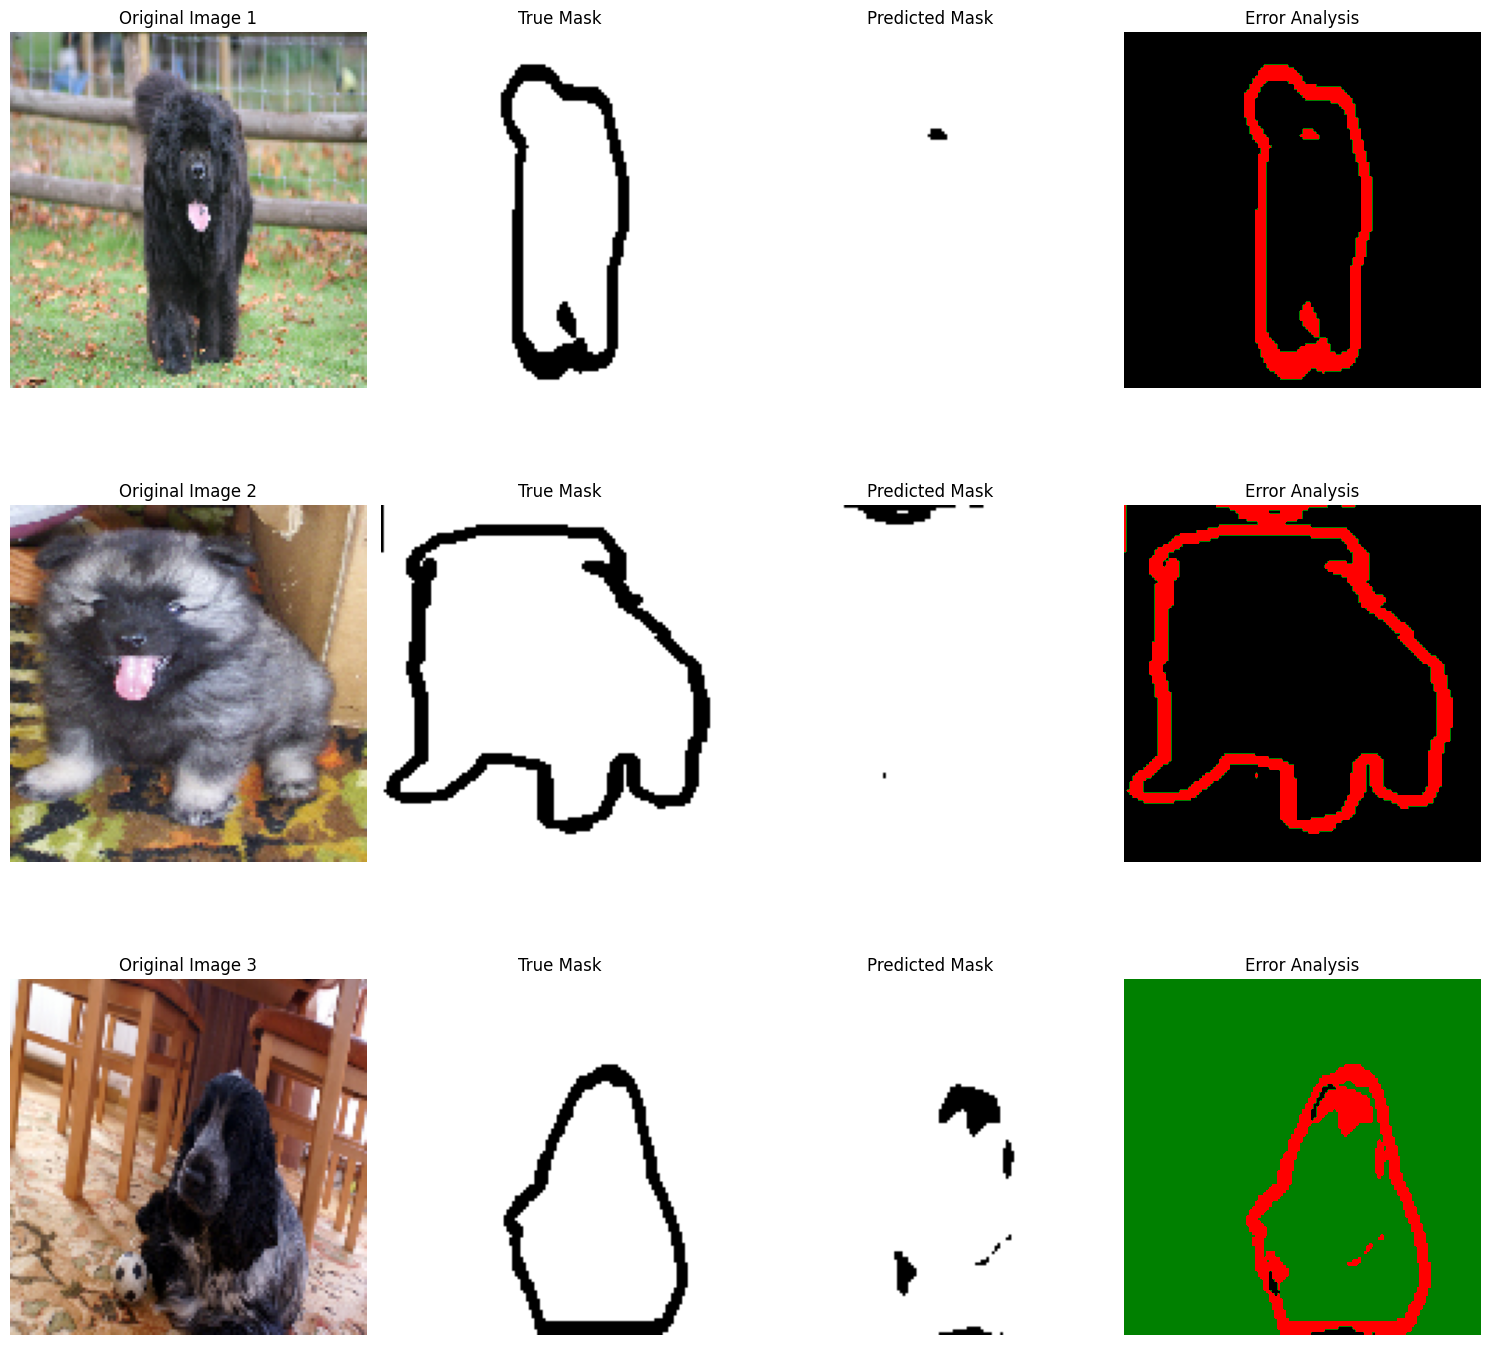

In [31]:
visualize_results(model, X_test, y_test, num_samples=3)

With Augmentation Results:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


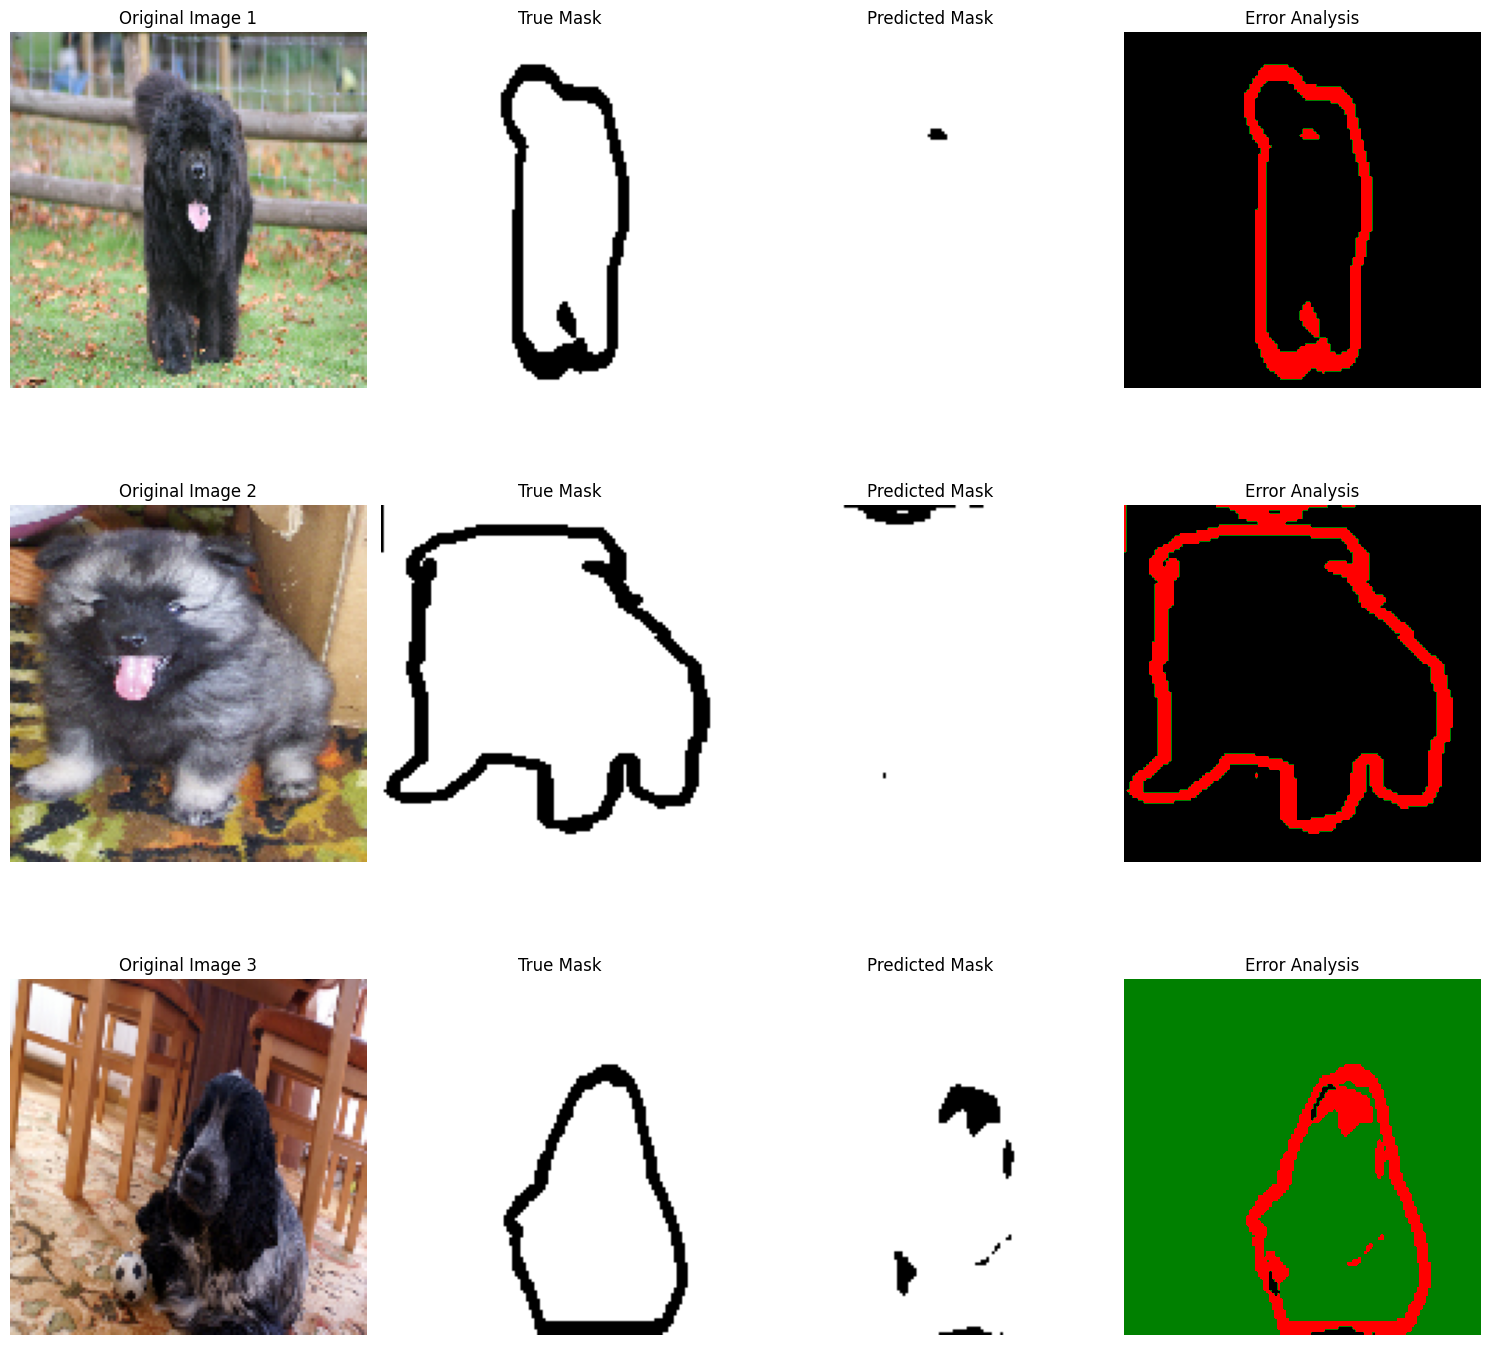

In [33]:
print("With Augmentation Results:")
visualize_results(model, X_test, y_test)

Without Augmentation Results:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


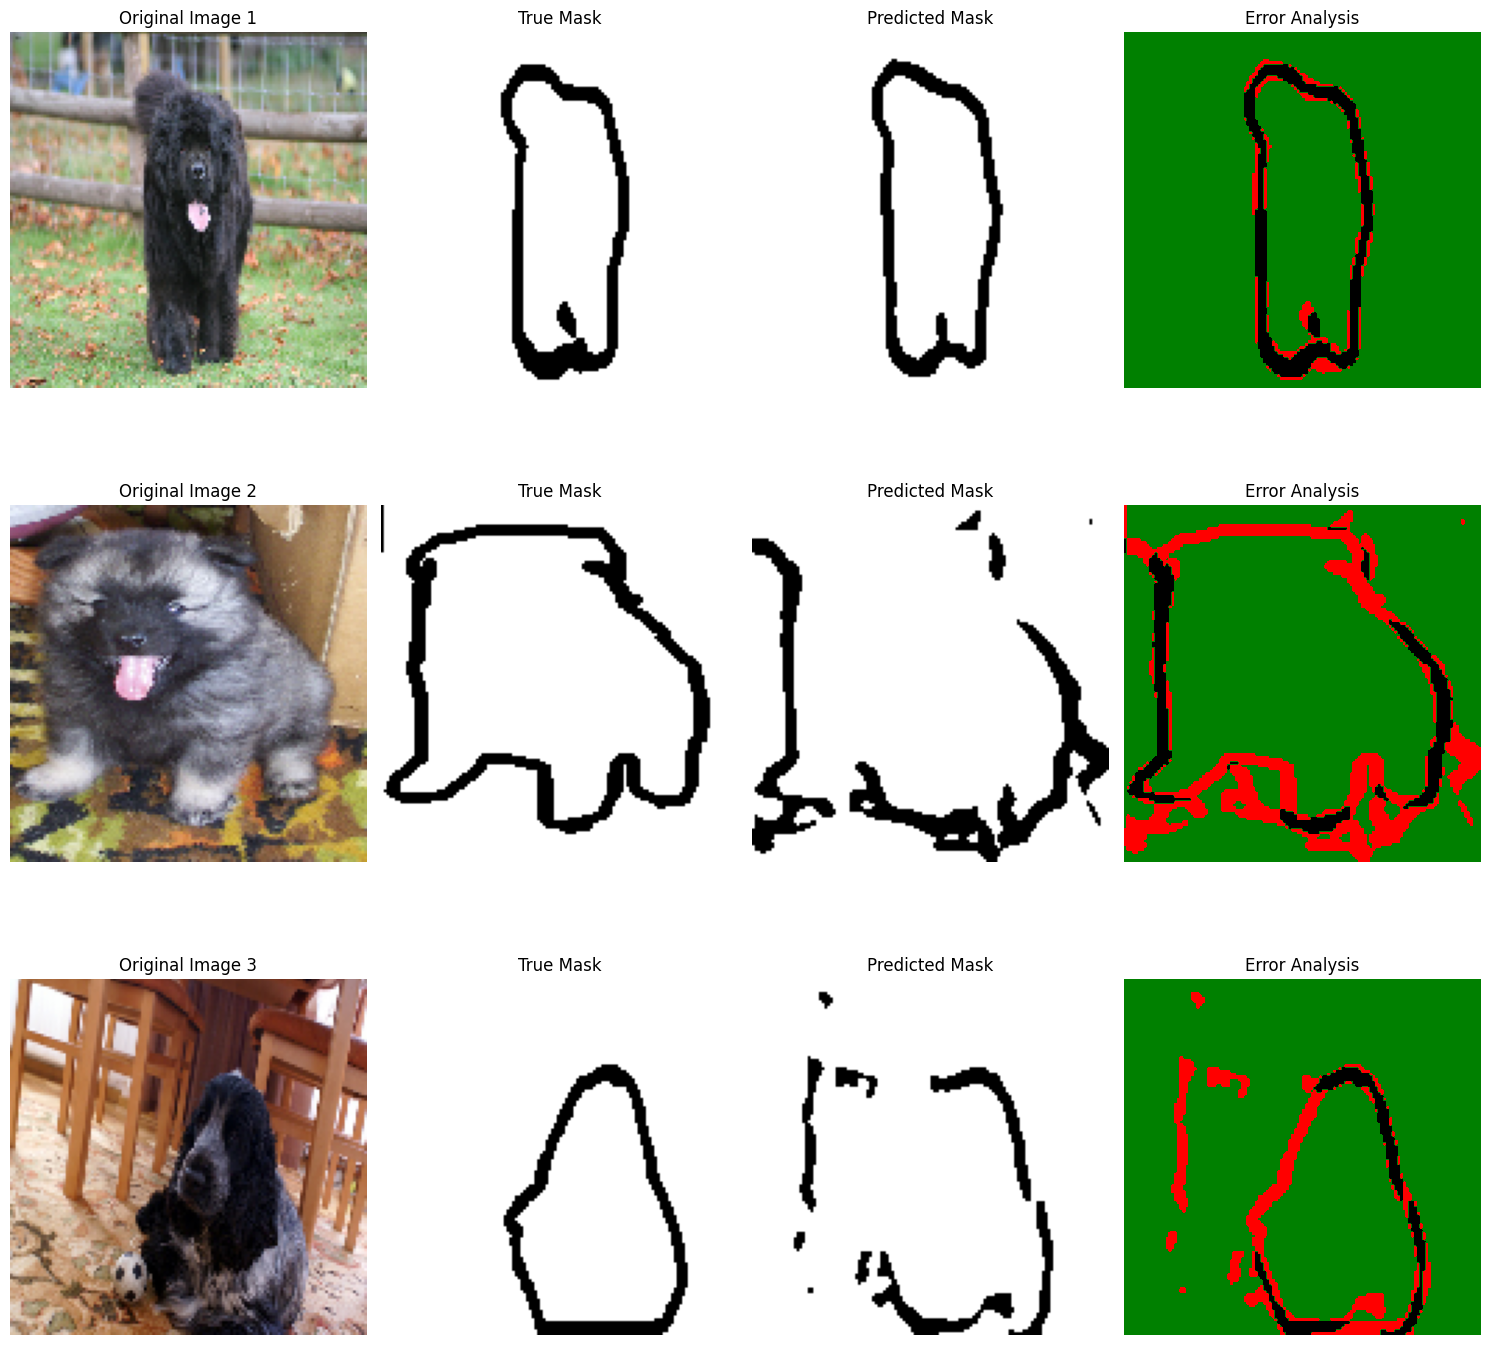

In [34]:
print("Without Augmentation Results:")
visualize_results(model_no_aug, X_test, y_test)